In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

2023-12-29 13:18:39.340136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__

'2.9.1'

In [18]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input) 

train_ds = train_gen.flow_from_directory(
    './dataset/train',
    target_size=(150, 150),
    batch_size=55
)

train_ds.class_indices

Found 6600 images belonging to 20 classes.


{'Abyssinian': 0,
 'American Bobtail': 1,
 'American Curl': 2,
 'American Shorthair': 3,
 'Bengal': 4,
 'Birman': 5,
 'Bombay': 6,
 'British Shorthair': 7,
 'Egyptian Mau': 8,
 'Exotic Shorthair': 9,
 'Maine Coon': 10,
 'Manx': 11,
 'Norwegian Forest': 12,
 'Persian': 13,
 'Ragdoll': 14,
 'Russian Blue': 15,
 'Scottish Fold': 16,
 'Siamese': 17,
 'Sphynx': 18,
 'Turkish Angora': 19}

In [9]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './dataset/test',
    target_size=(150, 150),
    batch_size=30,
    shuffle=False
)

Found 400 images belonging to 20 classes.


In [10]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

def make_model(learning_rate=0.0001):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False


    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(20)(vectors)
    model = keras.Model(inputs, outputs)


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [15]:
scores = {}
# already tested with big values (like 0.01 and higher) results were all less than 0.0001's accuracy
for lr in [0.0001, 0.0005, 0.00075, 0.001]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/30
120/120 [==============================] - 47s 372ms/step - loss: 2.6190 - accuracy: 0.2198 - val_loss: 2.1825 - val_accuracy: 0.3675
Epoch 2/30
120/120 [==============================] - 44s 368ms/step - loss: 1.9555 - accuracy: 0.4326 - val_loss: 1.7992 - val_accuracy: 0.4550
Epoch 3/30
120/120 [==============================] - 44s 368ms/step - loss: 1.6798 - accuracy: 0.5029 - val_loss: 1.6167 - val_accuracy: 0.4900
Epoch 4/30
120/120 [==============================] - 44s 367ms/step - loss: 1.5263 - accuracy: 0.5421 - val_loss: 1.5100 - val_accuracy: 0.5125
Epoch 5/30
120/120 [==============================] - 44s 367ms/step - loss: 1.4266 - accuracy: 0.5664 - val_loss: 1.4393 - val_accuracy: 0.5225
Epoch 6/30
120/120 [==============================] - 44s 363ms/step - loss: 1.3556 - accuracy: 0.5874 - val_loss: 1.3878 - val_accuracy: 0.5375
Epoch 7/30
120/120 [==============================] - 44s 366ms/step - loss: 1.2983 - accuracy: 0.6032 - val_loss: 1.3479 -

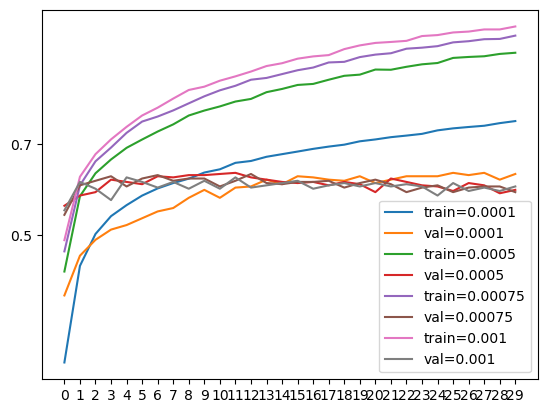

In [17]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(30))
plt.yticks([0.50, 0.70])
plt.legend()

In [18]:
learning_rate = 0.0005

In [20]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [21]:
model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
120/120 [==============================] - 47s 376ms/step - loss: 1.8764 - accuracy: 0.4239 - val_loss: 1.4542 - val_accuracy: 0.5275
Epoch 2/10
120/120 [==============================] - 44s 370ms/step - loss: 1.3069 - accuracy: 0.5888 - val_loss: 1.3060 - val_accuracy: 0.5900
Epoch 3/10
120/120 [==============================] - 44s 367ms/step - loss: 1.1573 - accuracy: 0.6362 - val_loss: 1.2192 - val_accuracy: 0.6150
Epoch 4/10
120/120 [==============================] - 44s 367ms/step - loss: 1.0558 - accuracy: 0.6724 - val_loss: 1.1698 - val_accuracy: 0.6275
Epoch 5/10
120/120 [==============================] - 44s 365ms/step - loss: 0.9891 - accuracy: 0.6924 - val_loss: 1.1581 - val_accuracy: 0.6250
Epoch 6/10
120/120 [==============================] - 44s 364ms/step - loss: 0.9304 - accuracy: 0.7095 - val_loss: 1.1645 - val_accuracy: 0.6175
Epoch 7/10
120/120 [==============================] - 44s 366ms/step - loss: 0.8758 - accuracy: 0.7374 - val_loss: 1.1455 - val_ac

In [24]:
def make_model(learning_rate=0.0005, size_inner=5000):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(20)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [27]:
scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=25, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/25
120/120 [==============================] - 47s 374ms/step - loss: 2.6210 - accuracy: 0.1973 - val_loss: 2.3785 - val_accuracy: 0.2825
Epoch 2/25
120/120 [==============================] - 44s 369ms/step - loss: 2.1752 - accuracy: 0.3412 - val_loss: 2.0524 - val_accuracy: 0.3875
Epoch 3/25
120/120 [==============================] - 44s 367ms/step - loss: 1.8497 - accuracy: 0.4518 - val_loss: 1.8130 - val_accuracy: 0.4825
Epoch 4/25
120/120 [==============================] - 44s 367ms/step - loss: 1.6265 - accuracy: 0.5179 - val_loss: 1.6569 - val_accuracy: 0.5050
Epoch 5/25
120/120 [==============================] - 44s 366ms/step - loss: 1.4749 - accuracy: 0.5556 - val_loss: 1.5365 - val_accuracy: 0.5150
Epoch 6/25
120/120 [==============================] - 44s 367ms/step - loss: 1.3707 - accuracy: 0.5898 - val_loss: 1.4693 - val_accuracy: 0.5525
Epoch 7/25
120/120 [==============================] - 44s 368ms/step - loss: 1.2956 - accuracy: 0.6048 - val_loss: 1.4331 - val

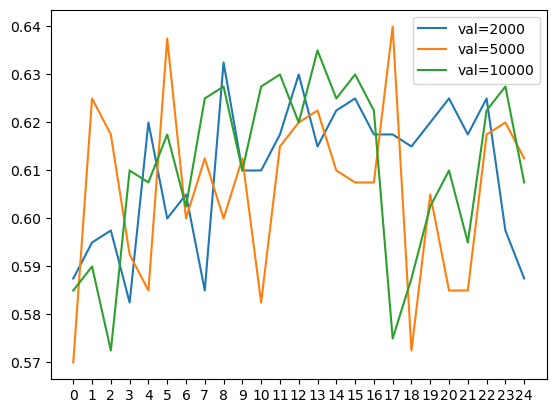

In [32]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(25))
plt.legend()

In [29]:
scores = {}

for size in [2000, 5000, 10000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=25, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

2000
Epoch 1/25
120/120 [==============================] - 47s 379ms/step - loss: 1.5188 - accuracy: 0.5227 - val_loss: 1.2837 - val_accuracy: 0.5875
Epoch 2/25
120/120 [==============================] - 44s 368ms/step - loss: 1.0010 - accuracy: 0.6709 - val_loss: 1.1600 - val_accuracy: 0.5950
Epoch 3/25
120/120 [==============================] - 45s 370ms/step - loss: 0.7708 - accuracy: 0.7482 - val_loss: 1.1887 - val_accuracy: 0.5975
Epoch 4/25
120/120 [==============================] - 44s 366ms/step - loss: 0.6069 - accuracy: 0.8045 - val_loss: 1.2666 - val_accuracy: 0.5825
Epoch 5/25
120/120 [==============================] - 44s 367ms/step - loss: 0.4834 - accuracy: 0.8482 - val_loss: 1.2863 - val_accuracy: 0.6200
Epoch 6/25
120/120 [==============================] - 44s 365ms/step - loss: 0.3535 - accuracy: 0.8952 - val_loss: 1.3208 - val_accuracy: 0.6000
Epoch 7/25
120/120 [==============================] - 44s 367ms/step - loss: 0.2795 - accuracy: 0.9171 - val_loss: 1.2892 - v

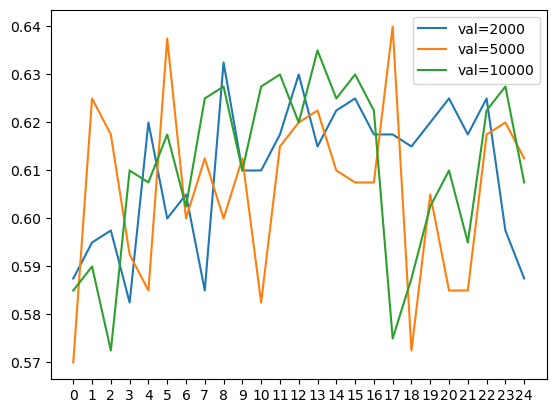

In [35]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(25))
plt.legend()

In [40]:
def make_model(learning_rate=0.0005, size_inner=5000, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(20)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [41]:
size = 5000
learning_rate = 0.0005
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=40, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/40
120/120 [==============================] - 47s 374ms/step - loss: 1.5482 - accuracy: 0.5264 - val_loss: 1.2244 - val_accuracy: 0.5975
Epoch 2/40
120/120 [==============================] - 44s 365ms/step - loss: 0.9899 - accuracy: 0.6792 - val_loss: 1.2383 - val_accuracy: 0.6025
Epoch 3/40
120/120 [==============================] - 44s 365ms/step - loss: 0.7690 - accuracy: 0.7465 - val_loss: 1.1855 - val_accuracy: 0.6175
Epoch 4/40
120/120 [==============================] - 44s 367ms/step - loss: 0.5930 - accuracy: 0.8115 - val_loss: 1.2694 - val_accuracy: 0.6100
Epoch 5/40
120/120 [==============================] - 44s 365ms/step - loss: 0.4515 - accuracy: 0.8558 - val_loss: 1.2256 - val_accuracy: 0.6025
Epoch 6/40
120/120 [==============================] - 44s 368ms/step - loss: 0.3358 - accuracy: 0.8938 - val_loss: 1.4213 - val_accuracy: 0.5875
Epoch 7/40
120/120 [==============================] - 44s 366ms/step - loss: 0.2419 - accuracy: 0.9309 - val_loss: 1.3912 - va

In [43]:
size = 5000
learning_rate = 0.0005
scores = {}

for droprate in [0.6, 0.7, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=50, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.6
Epoch 1/50
120/120 [==============================] - 45s 356ms/step - loss: 1.7641 - accuracy: 0.4676 - val_loss: 1.2736 - val_accuracy: 0.5950
Epoch 2/50
120/120 [==============================] - 42s 351ms/step - loss: 1.2927 - accuracy: 0.5773 - val_loss: 1.2161 - val_accuracy: 0.6075
Epoch 3/50
120/120 [==============================] - 42s 351ms/step - loss: 1.1222 - accuracy: 0.6394 - val_loss: 1.2562 - val_accuracy: 0.5750
Epoch 4/50
120/120 [==============================] - 42s 348ms/step - loss: 1.0332 - accuracy: 0.6647 - val_loss: 1.2482 - val_accuracy: 0.6075
Epoch 5/50
120/120 [==============================] - 42s 351ms/step - loss: 0.9313 - accuracy: 0.6942 - val_loss: 1.2263 - val_accuracy: 0.6275
Epoch 6/50
120/120 [==============================] - 42s 347ms/step - loss: 0.8498 - accuracy: 0.7198 - val_loss: 1.2009 - val_accuracy: 0.6150
Epoch 7/50
120/120 [==============================] - 42s 348ms/step - loss: 0.7759 - accuracy: 0.7406 - val_loss: 1.1447 - va

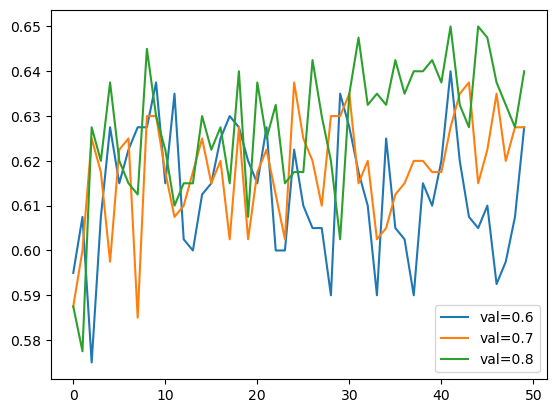

In [44]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.legend()

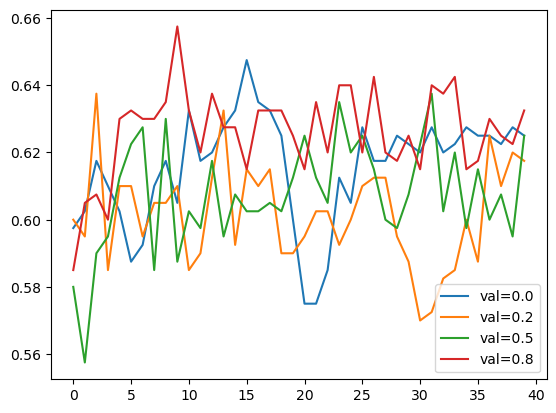

In [42]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.legend()

## Data Augmentation

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen_tran = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,                       
    horizontal_flip=True,       
    vertical_flip=True,         
    fill_mode='nearest'         
)

train_ds_tran = train_gen_tran.flow_from_directory(
    './dataset/train',
    target_size=(150, 150),
    batch_size=55
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './dataset/test',
    target_size=(150, 150),
    batch_size=55,
    shuffle=False
)

Found 6600 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}_{accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq="epoch"
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

input_size = 150

In [27]:
def make_model(input_size=299, learning_rate=0.0005, size_inner=5000,
               droprate=0.8):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(20)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
learning_rate = 0.0005
size = 5000
droprate = 0.8

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds_tran, epochs=150, validation_data=val_ds,
                   callbacks=[checkpoint])

In [23]:
learning_rate = 0.0005
size = 5000
droprate = 0.8

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=150, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/150
120/120 [==============================] - 47s 377ms/step - loss: 2.0527 - accuracy: 0.4094 - val_loss: 1.3163 - val_accuracy: 0.5675
Epoch 2/150
120/120 [==============================] - 44s 368ms/step - loss: 1.5120 - accuracy: 0.5191 - val_loss: 1.2842 - val_accuracy: 0.5650
Epoch 3/150
120/120 [==============================] - 44s 366ms/step - loss: 1.3754 - accuracy: 0.5632 - val_loss: 1.1852 - val_accuracy: 0.6150
Epoch 4/150
120/120 [==============================] - 44s 367ms/step - loss: 1.2994 - accuracy: 0.5826 - val_loss: 1.1928 - val_accuracy: 0.5875
Epoch 5/150
120/120 [==============================] - 44s 368ms/step - loss: 1.2119 - accuracy: 0.6067 - val_loss: 1.1576 - val_accuracy: 0.6125
Epoch 6/150
120/120 [==============================] - 44s 365ms/step - loss: 1.1662 - accuracy: 0.6277 - val_loss: 1.1620 - val_accuracy: 0.6100
Epoch 7/150
120/120 [==============================] - 44s 362ms/step - loss: 1.1225 - accuracy: 0.6352 - val_loss: 1.1349 -

## Final Model

In [2]:
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_model(input_size=299, learning_rate=0.0005, size_inner=5000,
               droprate=0.8):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(20)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [3]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    fill_mode='nearest'
)

train_ds = train_gen.flow_from_directory(
    './dataset/train',
    target_size=(299, 299),
    batch_size=55
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './dataset/test',
    target_size=(299, 299),
    batch_size=30,
    shuffle=False
)


Found 6600 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [4]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_final_{epoch:02d}_{val_accuracy:.3f}_{accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

input_size = 299

In [6]:
learning_rate = 0.0005
size = 5000
droprate = 0.8 

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=150, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/150
120/120 [==============================] - 161s 1s/step - loss: 1.6304 - accuracy: 0.4802 - val_loss: 1.0084 - val_accuracy: 0.6900
Epoch 2/150
120/120 [==============================] - 153s 1s/step - loss: 1.1817 - accuracy: 0.6118 - val_loss: 0.9994 - val_accuracy: 0.6650
Epoch 3/150
120/120 [==============================] - 152s 1s/step - loss: 1.0830 - accuracy: 0.6420 - val_loss: 0.8513 - val_accuracy: 0.7125
Epoch 4/150
120/120 [==============================] - 152s 1s/step - loss: 1.0215 - accuracy: 0.6618 - val_loss: 0.8134 - val_accuracy: 0.7300
Epoch 5/150
120/120 [==============================] - 150s 1s/step - loss: 0.9529 - accuracy: 0.6827 - val_loss: 0.7725 - val_accuracy: 0.7275
Epoch 6/150
120/120 [==============================] - 150s 1s/step - loss: 0.9193 - accuracy: 0.6912 - val_loss: 0.7712 - val_accuracy: 0.7375
Epoch 7/150
120/120 [==============================] - 151s 1s/step - loss: 0.8929 - accuracy: 0.6974 - val_loss: 0.7298 - val_accuracy:

In [3]:
#loading and using the model for a test:

import tensorflow as tf
from tensorflow import keras


model = keras.models.load_model('Deployment/xception_final_139_0.820_0.936.h5')


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.applications.xception import preprocess_input


path = './maine-coon.jpg'
img = load_img(path, target_size=(299, 299))

import numpy as np

x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
classes = [
'Abyssinian'
 ,'American Bobtail'
 ,'American Curl'
 ,'American Shorthair'
 ,'Bengal'
 ,'Birman'
 ,'Bombay'
 ,'British Shorthair'
 ,'Egyptian Mau'
 ,'Exotic Shorthair'
 ,'Maine Coon'
 ,'Manx'
 ,'Norwegian Forest'
 ,'Persian'
 ,'Ragdoll'
 ,'Russian Blue'
 ,'Scottish Fold'
 ,'Siamese'
 ,'Sphynx'
 ,'Turkish Angora']


dict(zip(classes, pred[0]))


1/1 [==============================] - 2s 2s/step


{'Abyssinian': -16.140371,
 'American Bobtail': -4.0648804,
 'American Curl': 2.9581392,
 'American Shorthair': -9.016632,
 'Bengal': -6.7614293,
 'Birman': -9.949476,
 'Bombay': -19.382736,
 'British Shorthair': -9.170991,
 'Egyptian Mau': -14.102277,
 'Exotic Shorthair': -13.084435,
 'Maine Coon': 7.5696793,
 'Manx': -3.5071552,
 'Norwegian Forest': 6.390111,
 'Persian': -12.094672,
 'Ragdoll': -8.214117,
 'Russian Blue': -18.505823,
 'Scottish Fold': -9.947857,
 'Siamese': -20.022594,
 'Sphynx': -19.345737,
 'Turkish Angora': -10.712449}

In [17]:
from scipy.special import softmax

probabilities = softmax(pred, axis=1)

dict(zip(classes, probabilities[0]))

# It works well! (Notice the Maine Coon with 75.91% probability)

Probabilities:



{'Abyssinian': 3.8295443e-11,
 'American Bobtail': 6.7215e-06,
 'American Curl': 0.007542667,
 'American Shorthair': 4.7527802e-08,
 'Bengal': 4.5328363e-07,
 'Birman': 1.8699012e-08,
 'Bombay': 1.4962561e-12,
 'British Shorthair': 4.0729674e-08,
 'Egyptian Mau': 2.939549e-10,
 'Exotic Shorthair': 8.134364e-10,
 'Maine Coon': 0.75908643,
 'Manx': 1.1740404e-05,
 'Norwegian Forest': 0.23335184,
 'Persian': 2.1886255e-09,
 'Ragdoll': 1.0604143e-07,
 'Russian Blue': 3.5962047e-12,
 'Scottish Fold': 1.8729317e-08,
 'Siamese': 7.890763e-13,
 'Sphynx': 1.5526524e-12,
 'Turkish Angora': 8.718949e-09}